In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'CPU')
device

device(type='cuda')

Loading Finetuning model

In [5]:
model_id="diffusion_ft"
pipe_ft=DDPMPipeline.from_pretrained(model_id).to(device)
#Set a new timesteps for scheduler


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
scheduler=DDIMScheduler.from_pretrained(model_id+'/scheduler')
scheduler.set_timesteps(num_inference_steps=40)

In [4]:
batch_size=4
img_size=256

Generate the images from the fine tuning model 

40it [00:22,  1.77it/s]


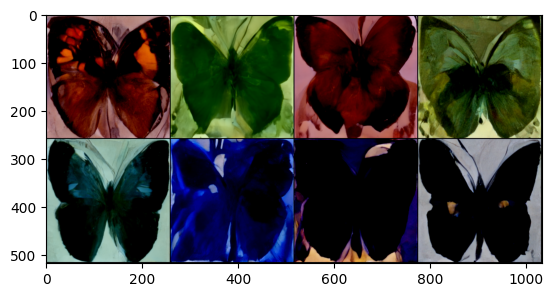

In [11]:
X=torch.randn(batch_size,3,img_size,img_size).to(device)
for i,t in tqdm(enumerate(scheduler.timesteps)):
    input=scheduler.scale_model_input(X,t)
    with torch.no_grad():
        noise_pred=pipe_ft.unet(input,t)['sample']
    out_put=scheduler.step(noise_pred,t,X)
    X=out_put.prev_sample
grid=torchvision.utils.make_grid(X, nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1)) 


Guidance

In [5]:
#Calculate the difference between the color of image and the target color.
def color_loss(img, color=(0.8, 0.3, 0.6)):
    target=torch.tensor(color).to(device)
    target=target[None,:,None,None]
    error=torch.abs(img-target).mean()
    return error

In [6]:
from PIL import ImageColor

In [9]:
ImageColor.getcolor('pink', 'RGB')

(255, 192, 203)

In [18]:
#At each iteration, we get the prediction image, then using the descent 
# gradient method on image to minimizer the difference between the
#  predict image and target color. 
def gererate(color, guidance_scale,bs):
    target_color=ImageColor.getcolor(color, 'RGB')
    target_color=[a/255 for a in target_color]
    imgs=torch.randn(bs,3,256,256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        #Optimimizer on images
        imgs=imgs.detach().requires_grad_()
        #prepare the input
        model_input=scheduler.scale_model_input(imgs,t)
        #Predict the noise
        with torch.no_grad():
            noise_pred=pipe_ft.unet(model_input,t)['sample']
        #Get the predict of img noising
        imgs_0=scheduler.step(noise_pred,t,imgs).pred_original_sample
        #loss
        loss=color_loss(imgs_0, target_color)*guidance_scale
        if i%10==0 or i==39:
            print(f'Loss of {i} step: {loss}')
        #calculate the gradient
        cond_grad=-torch.autograd.grad(loss, imgs_0)[0]
        imgs=imgs.detach()+cond_grad
        imgs=scheduler.step(noise_pred, t, imgs).prev_sample
    return imgs



In [22]:
img=gererate('pink', 40, 8)

1it [00:00,  1.73it/s]

Loss of 0 step: 33.70376205444336


11it [00:06,  1.76it/s]

Loss of 10 step: 30.702720642089844


21it [00:11,  1.76it/s]

Loss of 20 step: 30.7797794342041


31it [00:17,  1.75it/s]

Loss of 30 step: 30.793174743652344


40it [00:22,  1.76it/s]

Loss of 39 step: 30.7933406829834


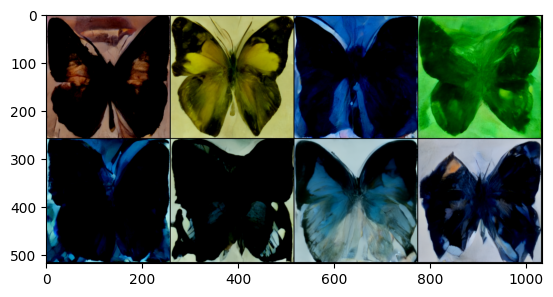

In [23]:
img_grid=torchvision.utils.make_grid(img, nrow=4)
plt.imshow(img_grid.permute(1,2,0).cpu().clip(0,1))